# Contexto:

O objetivo deste projeto é extrair dados a partir de um filtro personalizado no Jira, utilizado em um projeto de atendimento de tickets. Esses dados serão tratados e transformados para viabilizar sua exportação em formato CSV.
Além disso, como melhoria existe a possibilidade de integração com o BigQuery, visando a criação de um dashboard interativo para facilitar a análise e auxiliar na tomada de decisões estratégicas relacionadas ao atendimento e à performance operacional.


In [ ]:
# Instalando Jira
!pip install jira

In [4]:
import pandas as pd
from jira import JIRA
from datetime import datetime, timedelta


In [5]:
# Conexão com o Jira usando credenciasis de e-mail e seu TOKEN
JIRA_SERVER = "https://seu_dominio.atlassian.net/"
EMAIL = "seuemail@.com"
API_TOKEN = "TOKEN"

# Conectar ao Jira
jira = JIRA(server=JIRA_SERVER, basic_auth=(EMAIL, API_TOKEN))

# ID do filtro no Jira
FILTER_ID = INSIRA O ID DO FILTRO
query = f"filter={FILTER_ID}"

In [8]:
# Buscar todas as issues com paginação
issues = []
start_at = 0
batch_size = 100  # Lote máximo permitido pelo Jira

while True:
    batch = jira.search_issues(query, startAt=start_at, maxResults=batch_size)

    if not batch:  # Se não houver mais issues, encerra o loop
        break

    issues.extend(batch)  # Adiciona os resultados na lista principal
    start_at += batch_size  # Avança para a próxima página

print(f"✅ Total de {len(issues)} issues carregadas.")

# Criar uma lista com os dados das issues
dados = []
for issue in issues:
    fields = issue.fields

    # ✅ Removendo "[System] " do campo "Tipo do Item"
    tipo_item = fields.issuetype.name.replace("[System] ", "") if fields.issuetype else ""

    # ✅ Ajustando CATEGORIA para incluir CATEGORIA INCIDENTE, se necessário
    categoria = fields.customfield_10150 if hasattr(fields, 'customfield_10150') and fields.customfield_10150 else fields.customfield_10277 if hasattr(fields, 'customfield_10277') else ""

    # ✅ Modificando STATUS: "Concluída" → "Resolvido"
    status = fields.status.name.replace("Concluída", "Resolvido") if fields.status else ""

    dados.append({
        "TIPO DE ITEM": tipo_item,
        "ID": issue.key,
        "RESUMO": fields.summary if fields.summary else "",
        "CHAPTER": fields.customfield_10149 if hasattr(fields, 'customfield_10149') else "",
        "RESPONSAVEL": fields.assignee.displayName if fields.assignee else "",
        "RELATOR": fields.reporter.displayName if fields.reporter else "",
        "CATEGORIA": categoria,
        "PRIORIDADE": fields.priority.name if fields.priority else "",
        "STATUS": status,
        "MOTIVO DE PENDENTE": fields.customfield_10125 if hasattr(fields, 'customfield_10125') else "",
        "PLATAFORMA": fields.customfield_10607 if hasattr(fields, 'customfield_10607') else "",
        "FREQUENCIA": fields.customfield_10609 if hasattr(fields, 'customfield_10609') else "",
        "RESOLUÇÃO": fields.resolution.name if fields.resolution else "Sem Resolução",
        "CRIADO": fields.created if fields.created else "",
        "RESOLVIDO": fields.resolutiondate if hasattr(fields, 'resolutiondate') else "",
        "TEMPO GASTO": fields.timespent if fields.timespent else 0,
        "INICIO DESENVOLVIMENTO": fields.customfield_10137 if hasattr(fields, 'customfield_10137') else "",
        "FINAL DESENVOLVIMENTO": fields.customfield_10138 if hasattr(fields, 'customfield_10138') else "",
    })

✅ Total de 185 issues carregadas.


In [ ]:
#CARREGAR E VIZUALIZAR OS DADOS
df = pd.DataFrame(dados)
display(df)

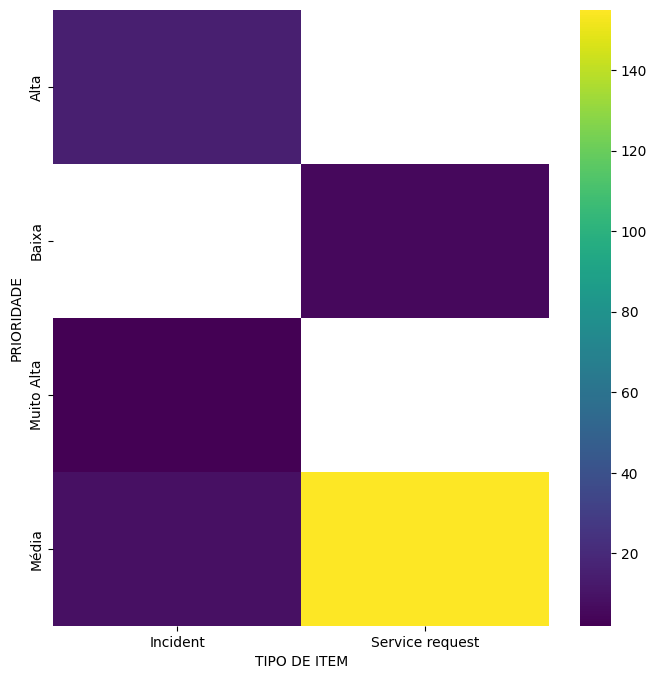

In [13]:
# @title TIPO DE ITEM vs PRIORIDADE

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['PRIORIDADE'].value_counts()
    for x_label, grp in df.groupby('TIPO DE ITEM')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('TIPO DE ITEM')
_ = plt.ylabel('PRIORIDADE')

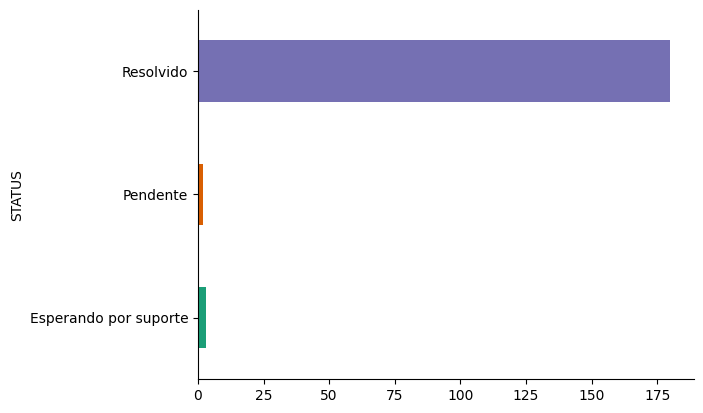

In [12]:
# @title STATUS

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('STATUS').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

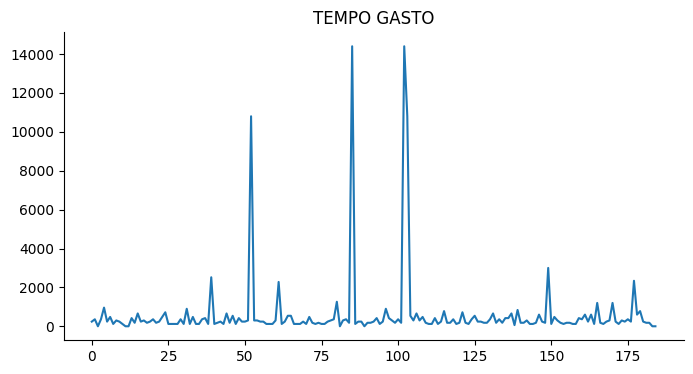

In [11]:
# @title TEMPO GASTO

from matplotlib import pyplot as plt
df['TEMPO GASTO'].plot(kind='line', figsize=(8, 4), title='TEMPO GASTO')
plt.gca().spines[['top', 'right']].set_visible(False)

In [14]:
#Exportando em CSV
df.to_csv("tickets_jira.csv", index=False, encoding="utf-8-sig")

print("✅ Dados salvos em 'tickets_jira.csv' com sucesso!")

✅ Dados salvos em 'tickets_jira.csv' com sucesso!
